In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline

%matplotlib inline

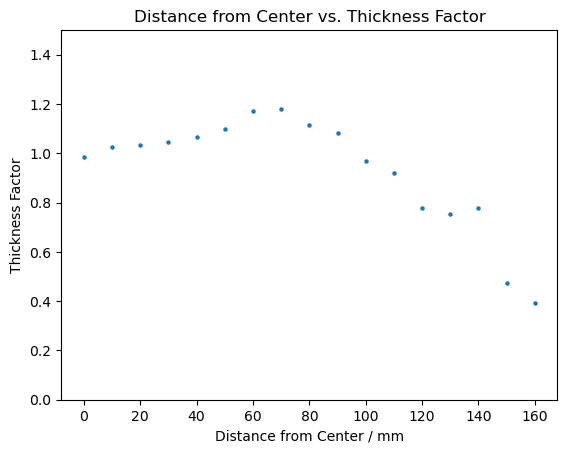

In [2]:
# Constants
PLATE_X = 237.62
PLATE_Y = 237.62
CENTER_X = PLATE_X / 2
CENTER_Y = PLATE_Y / 2

# Data points
distances = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160]
thickness_factors = [0.985, 1.027, 1.034, 1.044, 1.065, 1.10, 1.17, 1.18, 1.114, 1.082, 0.967, 0.922, 0.779, 0.754, 0.779, 0.473, 0.393]

plt.scatter(distances, thickness_factors, s=5)
plt.ylim(0, 1.5)
plt.xlabel('Distance from Center / mm')
plt.ylabel('Thickness Factor')
plt.title('Distance from Center vs. Thickness Factor')
plt.show()

Equation: 0.393 / (1 + exp(-0.088 * (x - 42.710))) + -33.000 / (1 + exp(-0.013 * (x - 423.011))) + 1.171
Root Mean Square Error (RMSE): 0.043


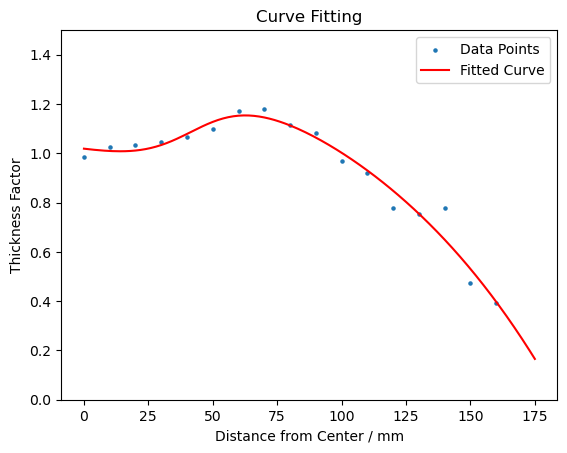

In [3]:
# Fit with logistic function and cubic spline to clamp boundary conditions

distances = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160]
thickness_factors = [0.985, 1.027, 1.034, 1.044, 1.065, 1.10, 1.17, 1.18, 1.114, 1.082, 0.967, 0.922, 0.779, 0.754, 0.779, 0.473, 0.393]
# thickness_factors = [0.667, 0.735, 0.761, 0.847, 0.932, 0.975, 1.043, 1.077, 1.154, 1.24, 1.24, 1.223, 1.231, 1.146, 1.052, 0.889, 0.787]

# Define the curve function
def curve_func(x, a1, b1, c1, a2, b2, c2, d):
    return c1 / (1 + np.exp(-a1 * (x - b1))) + c2 / (1 + np.exp(-a2 * (x - b2))) + d

initial_guesses = [0.1, 50, 0.25, 0.08, 100, -0.55, 1]

# Perform the curve fitting
popt, pcov = curve_fit(curve_func, distances, thickness_factors, p0=initial_guesses, maxfev=5000)
print(f'Equation: {popt[2]:.3f} / (1 + exp(-{popt[0]:.3f} * (x - {popt[1]:.3f}))) + {popt[5]:.3f} / (1 + exp(-{popt[3]:.3f} * (x - {popt[4]:.3f}))) + {popt[6]:.3f}')

# Generate x values for the curve
x_curve = np.arange(0, 176, 1)

# Generate y values using the fitted curve parameters
y_logistic = curve_func(x_curve, *popt)

# Fit with cubic spline to fix boundary conditions
cs = CubicSpline(x_curve, y_logistic, bc_type=((1, 0.), (2, 0.)))

# Generate y values using the fitted curve parameters
y_spline = cs(x_curve)

# Calculate the predicted values using the fitted curve
y_predicted = cs(distances)

# Calculate the root mean square error (RMSE)
rmse = np.sqrt(np.mean((thickness_factors - y_predicted) ** 2))
print(f"Root Mean Square Error (RMSE): {rmse:.3f}")

# Plot the original data points and the fitted curve
plt.scatter(distances, thickness_factors, s=5, label='Data Points')
# plt.plot(x_curve, y_logistic, 'g-', label='Logistic Curve')
plt.plot(x_curve, y_spline, 'r-', label='Fitted Curve')
plt.xlabel('Distance from Center / mm')
plt.ylabel('Thickness Factor')
plt.ylim(0, 1.5)
plt.title('Curve Fitting')
plt.legend()
plt.show()

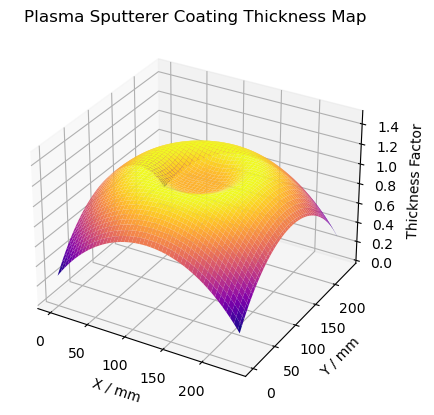

In [4]:
# Plot profile in 3D
x_ = np.linspace(0, PLATE_X, 100)
y_ = np.linspace(0, PLATE_Y, 100)
xx_, yy_ = np.meshgrid(x_, y_)
zz_ = cs(np.sqrt((xx_ - CENTER_X) ** 2 + (yy_ - CENTER_Y) ** 2))

# Create the figure and Axes3D subplot
fig = plt.figure()
ax = plt.axes(projection='3d')

# Plot the surface
ax.plot_surface(xx_, yy_, zz_, cmap='plasma', edgecolor='none')

# Customize the plot
ax.set_xlabel('X / mm')
ax.set_ylabel('Y / mm')
ax.set_zlabel('Thickness Factor')
ax.set_zlim(0, 1.5)
ax.set_title('Plasma Sputterer Coating Thickness Map')

# Display the plot
plt.show()

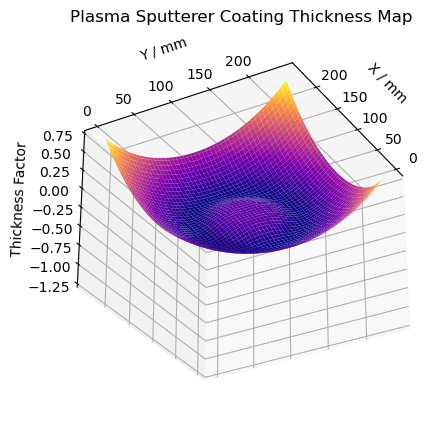

In [5]:
# Plot profile in 3D
x_ = np.linspace(0, PLATE_X, 100)
y_ = np.linspace(0, PLATE_Y, 100)
xx_, yy_ = np.meshgrid(x_, y_)
zz_f = -cs(np.sqrt((xx_ - CENTER_X) ** 2 + (yy_ - CENTER_Y) ** 2)) + 1

# Create the figure and Axes3D subplot
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(-30, 30)

# Plot the surface
ax.plot_surface(xx_, yy_, zz_f, cmap='plasma', edgecolor='none')

# Customize the plot
ax.set_xlabel('X / mm')
ax.set_ylabel('Y / mm')
ax.set_zlabel('Thickness Factor')
ax.set_zlim(-1.25, 0.75)
ax.set_title('Plasma Sputterer Coating Thickness Map', pad=20)

# Display the plot
plt.show()

#### Tape Targets

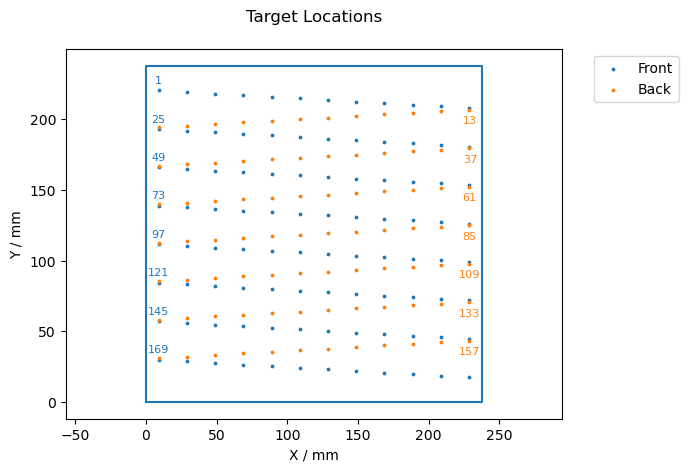

In [6]:
# Read the data from the csv file
front_data = np.genfromtxt("front_data.csv", delimiter=",")
front_x = front_data[:, 0]
front_y = -front_data[:, 1] # Flip the y values cause drawing coordinate is upside down

back_data = np.genfromtxt("back_data.csv", delimiter=",")
back_x = back_data[:, 0]
back_y = -back_data[:, 1] # Flip the y values cause drawing coordinate is upside down

n = np.arange(1, 181)
arg_n = np.where(((n-1) // 12) % 2 == 1, 0, 1)
front_n = n[arg_n == 1]
back_n = n[arg_n == 0]
for i, nn in enumerate(front_n):
    if (nn+11) % 12 == 0:
        plt.annotate(nn, (front_x[i], -front_y[i]+2*CENTER_Y), fontsize=8, xytext=(front_x[i], -front_y[i]+2*CENTER_Y+5), c='C0', ha='center')
for i, nn in enumerate(back_n):
    if (nn+11) % 12 == 0:
        plt.annotate(nn, (back_x[i], -back_y[i]+2*CENTER_Y), fontsize=8, xytext=(back_x[i]+PLATE_X-17.5, -back_y[i]+2*CENTER_Y-10), c='C1', ha='center')

# Plot a square
square_x = [0, PLATE_X, PLATE_X, 0, 0]
square_y = [0, 0, PLATE_Y, PLATE_Y, 0]
plt.plot(square_x, square_y)
plt.scatter(-front_x+PLATE_X, front_y, s=3, c='C0', label='Front') # Flip the x values for plotting only
plt.scatter(back_x, back_y, s=3, c='C1', label='Back')
plt.xlabel('X / mm')
plt.ylabel('Y / mm')
plt.axis("equal")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Target Locations', pad=20)
plt.show()

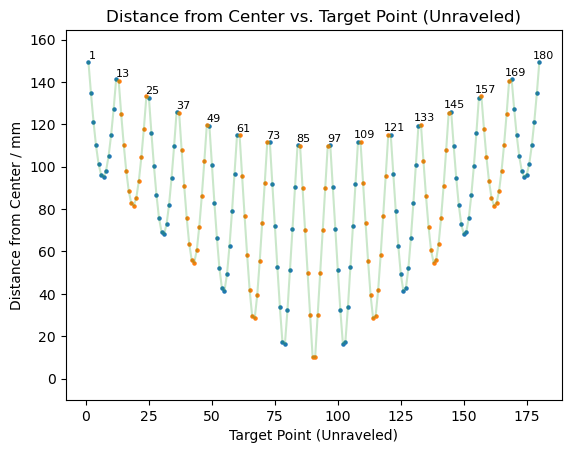

In [7]:
# Get distance of targets from center
front_radii = np.sqrt((front_x - CENTER_X) ** 2 + (front_y - CENTER_Y) ** 2)
back_radii = np.sqrt((back_x - CENTER_X) ** 2 + (back_y - CENTER_Y) ** 2)

merged_radii = []
for i in range(0, len(front_radii), 12):
    merged_radii.extend(front_radii[i:i+12])
    merged_radii.extend(back_radii[i:i+12])

n = np.arange(1, 181)
arg_n = np.where(((n-1) // 12) % 2 == 1, 0, 1)
front_n = n[arg_n == 1]
back_n = n[arg_n == 0]

# Add data labels to points
for i in range(0, len(n), 12):
    plt.annotate(str(i+1), (n[i], merged_radii[i]), fontsize=8, xytext=(n[i]+1.5, merged_radii[i]+0.75), ha='center', va='bottom')
plt.annotate(str(180), (n[-1], merged_radii[-1]), fontsize=8, xytext=(n[-1]+1.5, merged_radii[-1]+0.75), ha='center', va='bottom')

plt.scatter(front_n, front_radii, s=5)
plt.scatter(back_n, back_radii, s=5)
plt.plot(n, merged_radii, c='C2', alpha=0.25)
plt.xlabel('Target Point (Unraveled)')
plt.ylabel('Distance from Center / mm')
plt.ylim(-10, np.max(merged_radii) + 15)
plt.title('Distance from Center vs. Target Point (Unraveled)')
plt.show()

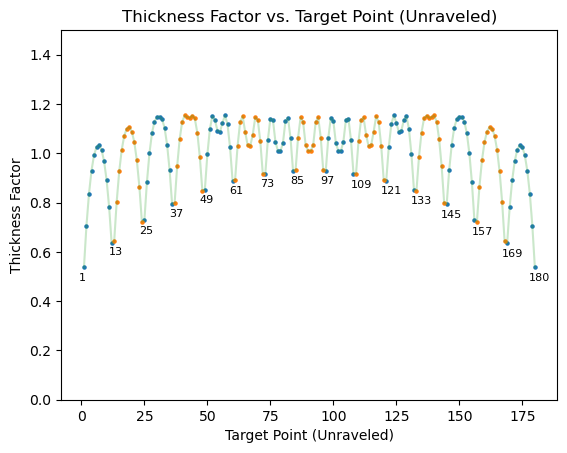

In [8]:
# Fit profile
front_tf = cs(front_radii)
back_tf = cs(back_radii)
target_tf = cs(merged_radii)

# Add data labels to points
for i in range(0, len(n), 12):
    plt.annotate(str(i+1), (n[i], target_tf[i]), fontsize=8, xytext=(n[i]-2.2, target_tf[i]-0.055))
plt.annotate(str(180), (n[-1], target_tf[-1]), fontsize=8, xytext=(n[-1]-2.2, target_tf[-1]-0.055))

plt.xlabel('Target Point (Unraveled)')
plt.ylabel('Thickness Factor')
plt.ylim(0, 1.5)
plt.plot(n, target_tf, c='C2', alpha=0.25)
plt.scatter(front_n, front_tf, s=5)
plt.scatter(back_n, back_tf, s=5)
plt.title('Thickness Factor vs. Target Point (Unraveled)')
plt.show()

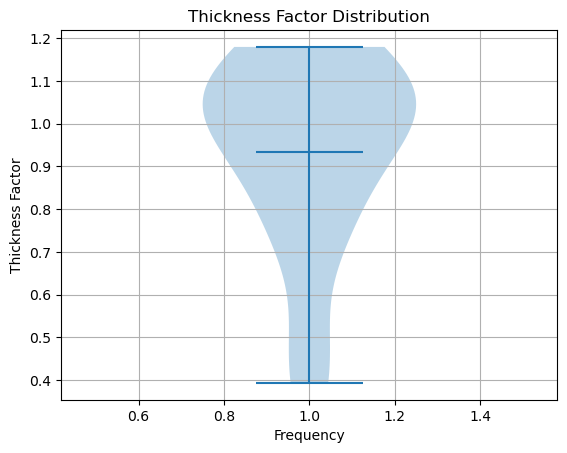

In [9]:
# Make violin plot
plt.violinplot(thickness_factors, showmeans=True)
plt.xlim(0.5, 1.5)
plt.ylim(0, 1.5)
plt.xlabel('Frequency')
plt.ylabel('Thickness Factor')
plt.title('Thickness Factor Distribution')
plt.axis('equal')
plt.grid()
plt.show()

Number of targets within 0.85 and 1.15:   146/180
Mean: 1.043   Std: 0.083


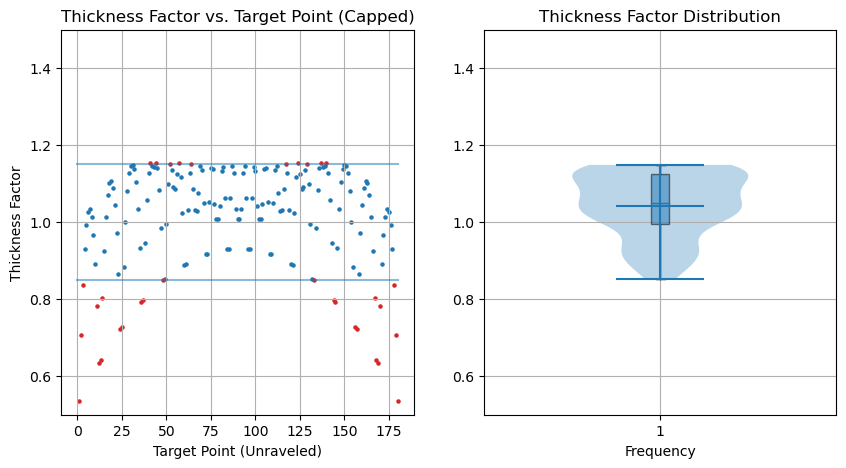

In [10]:
TF_FLOOR = 0.85
TF_CEILING = 1.15

arg_ok = np.where((target_tf >= TF_FLOOR) & (target_tf <= TF_CEILING))[0]
arg_notok = np.where((target_tf < TF_FLOOR) | (target_tf > TF_CEILING))[0]

n_ok = n[arg_ok]
target_tfok = target_tf[arg_ok]

n_notok = n[arg_notok]
target_tfnotok = target_tf[arg_notok]

print(f"Number of targets within {TF_FLOOR} and {TF_CEILING}:   {len(arg_ok)}/180")
print(f'Mean: {np.mean(target_tfok):.3f}   Std: {np.std(target_tfok):.3f}')

# Plot the ok points
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot line to show the floor and ceiling
ax1.plot([0, 180], [TF_FLOOR, TF_FLOOR], c='C0', alpha=0.5)
ax1.plot([0, 180], [TF_CEILING, TF_CEILING], c='C0', alpha=0.5)
ax1.scatter(n_ok, target_tfok, s=5)
ax1.scatter(n_notok, target_tfnotok, s=5, c='C3')
ax1.set_xlabel('Target Point (Unraveled)')
ax1.set_ylabel('Thickness Factor')
ax1.set_ylim(0.5, 1.5)
ax1.set_title('Thickness Factor vs. Target Point (Capped)')
ax1.grid()

box = ax2.boxplot(target_tfok, positions=[1], widths=0.05, patch_artist=True)
for patch in box['boxes']:
    patch.set_facecolor('C0')
    patch.set_alpha(0.5)
for median in box['medians']:
    median.set_color('C0')
ax2.violinplot(target_tfok, showmeans=True)
ax2.set_xlim(0.5, 1.5)
ax2.set_ylim(0.5, 1.5)
ax2.set_xlabel('Frequency')
ax2.set_title('Thickness Factor Distribution')
ax2.grid()
plt.show()

In [11]:
print(f'Minimum TF: {np.min(target_tf):.3f}')

Minimum TF: 0.537


#### Export to CSV

In [12]:
# Export data as df in csv
df = pd.DataFrame({'Target Number': n, 'Thickness Factor': target_tf})
df.to_csv('target_data.csv', index=False)

# Load csv head
with open('target_data.csv', 'r') as f:
    df = pd.read_csv(f)
print(df.head().to_string(index=False, justify='center'))

 Target Number  Thickness Factor
      1             0.536875    
      2             0.706903    
      3             0.836029    
      4             0.929955    
      5             0.992391    


In [13]:
# Export ok data as df in csv
df = pd.DataFrame({'Target Number': n_ok, 'Thickness Factor': target_tfok})
df.to_csv('target_data_capped.csv', index=False)

# Load csv head
with open('target_data_capped.csv', 'r') as f:
    df = pd.read_csv(f)
print(df.head().to_string(index=False, justify='center'))

 Target Number  Thickness Factor
      4             0.929955    
      5             0.992391    
      6             1.026176    
      7             1.033196    
      8             1.014024    


#### 3D Plot

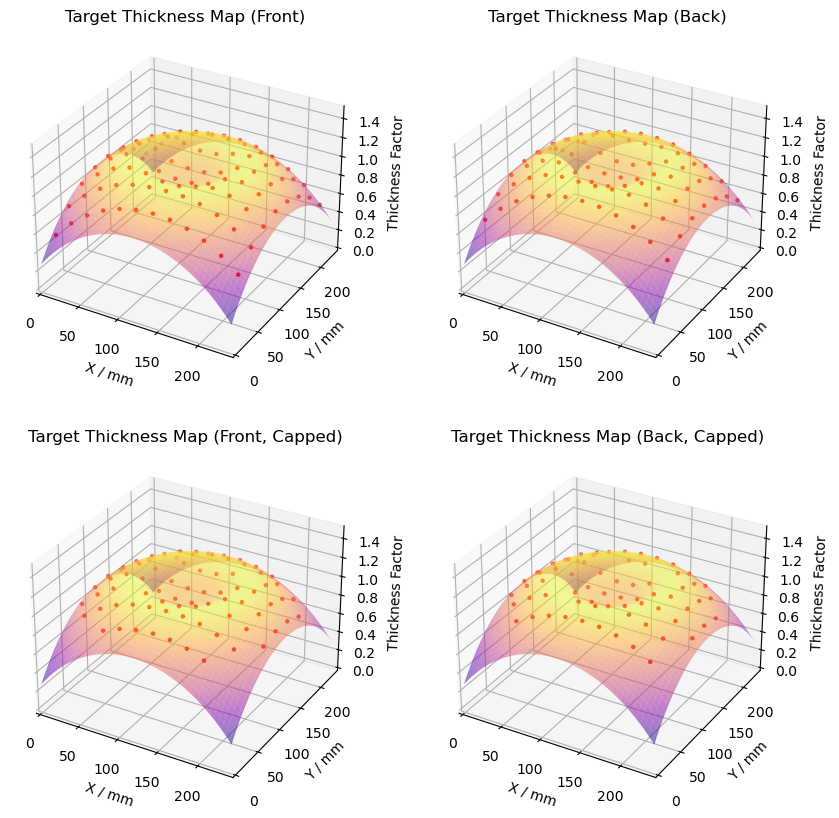

In [14]:
# Separate the columns of the data array
xf = front_data[:, 0]
yf = -front_data[:, 1]
zf = front_tf

arg_fok = np.where((zf >= TF_FLOOR) & (zf <= TF_CEILING))[0]
xfok = xf[arg_fok]
yfok = yf[arg_fok]
zfok = zf[arg_fok]

xb = back_data[:, 0]
yb = -back_data[:, 1]
zb = back_tf

arg_bok = np.where((zb >= TF_FLOOR) & (zb <= TF_CEILING))[0]
xbok = xb[arg_bok]
ybok = yb[arg_bok]
zbok = zb[arg_bok]

# Create the figure and Axes3D subplot
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, 0], projection='3d')
ax2 = fig.add_subplot(gs[0, 1], projection='3d')
ax3 = fig.add_subplot(gs[1, 0], projection='3d')
ax4 = fig.add_subplot(gs[1, 1], projection='3d')

# Plot the data points
ax1.scatter3D(xf, yf, zf, c='r', s=5)
ax1.plot_surface(xx_, yy_, zz_, cmap='plasma', edgecolor='none', alpha=0.5)
ax1.set_xlabel('X / mm')
ax1.set_ylabel('Y / mm')
ax1.set_zlabel('Thickness Factor')
ax1.set_xlim(0, PLATE_X)
ax1.set_ylim(0, PLATE_Y)
ax1.set_zlim(0, 1.5)
ax1.set_title('Target Thickness Map (Front)')

ax2.scatter3D(xb, yb, zb, c='r', s=5)
ax2.plot_surface(xx_, yy_, zz_, cmap='plasma', edgecolor='none', alpha=0.5)
ax2.set_xlabel('X / mm')
ax2.set_ylabel('Y / mm')
ax2.set_zlabel('Thickness Factor')
ax2.set_xlim(0, PLATE_X)
ax2.set_ylim(0, PLATE_Y)
ax2.set_zlim(0, 1.5)
ax2.set_title('Target Thickness Map (Back)')

ax3.scatter3D(xfok, yfok, zfok, c='r', s=5)
ax3.plot_surface(xx_, yy_, zz_, cmap='plasma', edgecolor='none', alpha=0.5)
ax3.set_xlabel('X / mm')
ax3.set_ylabel('Y / mm')
ax3.set_zlabel('Thickness Factor')
ax3.set_xlim(0, PLATE_X)
ax3.set_ylim(0, PLATE_Y)
ax3.set_zlim(0, 1.5)
ax3.set_title('Target Thickness Map (Front, Capped)')

ax4.scatter3D(xbok, ybok, zbok, c='r', s=5)
ax4.plot_surface(xx_, yy_, zz_, cmap='plasma', edgecolor='none', alpha=0.5)
ax4.set_xlabel('X / mm')
ax4.set_ylabel('Y / mm')
ax4.set_zlabel('Thickness Factor')
ax4.set_xlim(0, PLATE_X)
ax4.set_ylim(0, PLATE_Y)
ax4.set_zlim(0, 1.5)
ax4.set_title('Target Thickness Map (Back, Capped)')

plt.show()

#### Slides Coating

In [15]:
# read csv using pandas
df = pd.read_csv('target_data.csv')

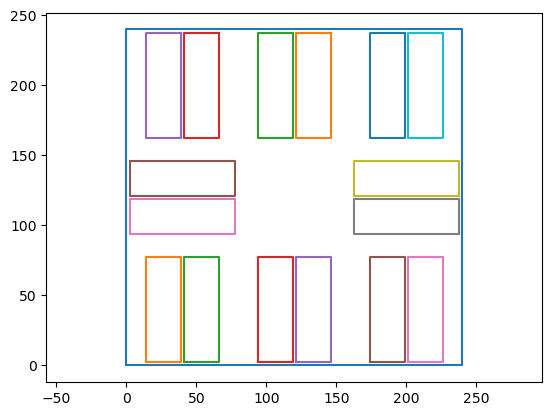

In [16]:
GPLATE_X = 240
GPLATE_Y = 240

SLIDE_LEN = 75
SLIDE_WID = 25
GAP = 1

slide_centers = np.array([[GPLATE_X/6-SLIDE_WID/2-GAP, GPLATE_Y/6, 0],
                            [GPLATE_X/6+SLIDE_WID/2+GAP, GPLATE_Y/6, 0],
                            [3*GPLATE_X/6-SLIDE_WID/2-GAP, GPLATE_Y/6, 0],
                            [3*GPLATE_X/6+SLIDE_WID/2+GAP, GPLATE_Y/6, 0],
                            [5*GPLATE_X/6-SLIDE_WID/2-GAP, GPLATE_Y/6, 0],
                            [5*GPLATE_X/6+SLIDE_WID/2+GAP, GPLATE_Y/6, 0],
                            [5*GPLATE_X/6, 3*GPLATE_Y/6-SLIDE_WID/2-GAP, 90],
                            [5*GPLATE_X/6, 3*GPLATE_Y/6+SLIDE_WID/2+GAP, 90],
                            [5*GPLATE_X/6+SLIDE_WID/2+GAP, 5*GPLATE_Y/6, 180],
                            [5*GPLATE_X/6-SLIDE_WID/2-GAP, 5*GPLATE_Y/6, 180],
                            [3*GPLATE_X/6+SLIDE_WID/2+GAP, 5*GPLATE_Y/6, 180],
                            [3*GPLATE_X/6-SLIDE_WID/2-GAP, 5*GPLATE_Y/6, 180],
                            [GPLATE_X/6+SLIDE_WID/2+GAP, 5*GPLATE_Y/6, 180],
                            [GPLATE_X/6-SLIDE_WID/2-GAP, 5*GPLATE_Y/6, 180],
                            [GPLATE_X/6, 3*GPLATE_Y/6+SLIDE_WID/2+GAP, 270],
                            [GPLATE_X/6, 3*GPLATE_Y/6-SLIDE_WID/2-GAP, 270]])

class Slide:

    def __init__(self, center, width, length, orientation):
        self.center = center
        self.length = length
        self.width = width
        self.orientation = orientation

        # Calculate the corners of the slide
        self.corners = np.array([[self.center[0]-self.width/2, self.center[1]-self.length/2],
                                [self.center[0]+self.width/2, self.center[1]-self.length/2],
                                [self.center[0]+self.width/2, self.center[1]+self.length/2],
                                [self.center[0]-self.width/2, self.center[1]+self.length/2]])
        # Transform the corners according to the orientation
        theta = np.deg2rad(self.orientation)
        # Rotate corner about slide center
        T = np.array([[np.cos(theta), -np.sin(theta), self.center[0] - self.center[0]*np.cos(theta) + self.center[1]*np.sin(theta)],
                        [np.sin(theta), np.cos(theta), self.center[1] - self.center[0]*np.sin(theta) - self.center[1]*np.cos(theta)],
                        [0, 0, 1]])
        for i in range(len(self.corners)):
            self.corners[i] = np.matmul(T, np.append(self.corners[i], 1))[:2]

        # Calculate the corners of the slide
        self.bottom_left = self.corners[0]
        self.bottom_right = self.corners[1]
        self.top_right = self.corners[2]
        self.top_left = self.corners[3]

    def contains(self, x, y):
        return self.point_in_triangle(x, y, self.bottom_left, self.bottom_right, self.top_right) or \
                self.point_in_triangle(x, y, self.bottom_left, self.top_right, self.top_left)

    def point_in_triangle(self, x, y, p1, p2, p3):
        # Check if the point is within the triangle using barycentric coordinates
        s = (p1[1]*p3[0] - p1[0]*p3[1] + (p3[1] - p1[1])*x + (p1[0] - p3[0])*y) / \
            (p1[1]*p3[0] - p1[0]*p3[1] + p3[1]*p2[0] - p3[0]*p2[1] + p2[1]*p1[0] - p2[0]*p1[1])

        t = (p1[0]*p2[1] - p1[1]*p2[0] + (p1[1] - p2[1])*x + (p2[0] - p1[0])*y) / \
            (p1[1]*p3[0] - p1[0]*p3[1] + p3[1]*p2[0] - p3[0]*p2[1] + p2[1]*p1[0] - p2[0]*p1[1])

        return (s > 0) & (t > 0) & (1 - s - t > 0)


gx = [0, 0, GPLATE_X, GPLATE_X, 0]
gy = [0, GPLATE_Y, GPLATE_Y, 0, 0]
plt.plot(gx, gy)
plt.axis('equal')

slide_rects = []
for i in range(len(slide_centers)):
    slide_rects.append(Slide((slide_centers[i, 0], slide_centers[i, 1]), SLIDE_WID, SLIDE_LEN, slide_centers[i, 2]))
    # print(f'Slide {i+1} corners: {slide_rects[i].bottom_left}, {slide_rects[i].bottom_right}, {slide_rects[i].top_right}, {slide_rects[i].top_left}')
    plt.plot(np.append(slide_rects[i].corners[:, 0], slide_rects[i].corners[0, 0]), np.append(slide_rects[i].corners[:, 1], slide_rects[i].corners[0, 1]))
    

In [17]:
x_s = np.arange(0, GPLATE_X, 1)
y_s = np.arange(0, GPLATE_Y, 1)
xx_s, yy_s = np.meshgrid(x_s, y_s)
zz_s = cs(np.sqrt((xx_s - CENTER_X) ** 2 + (yy_s - CENTER_Y) ** 2))

mask = np.zeros_like(zz_s)
for i in range(len(x_s)):
    for j in range(len(y_s)):
        for k in range(len(slide_rects)):
            if slide_rects[k].contains(x_s[i], y_s[j]):
                mask[j, i] = 1
xx_s = np.ma.masked_where(mask == 0, xx_s)
yy_s = np.ma.masked_where(mask == 0, yy_s)
zz_s = np.ma.masked_where(mask == 0, zz_s)


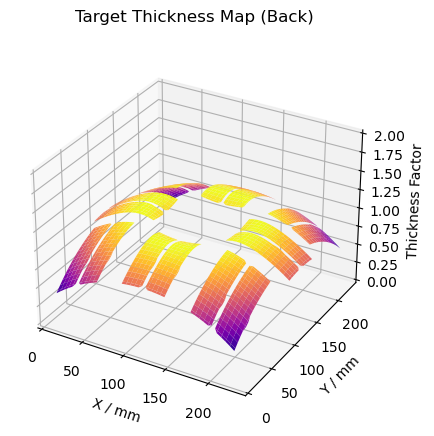

In [18]:
# Create the figure and Axes3D subplot
fig = plt.figure()
ax = plt.axes(projection='3d')

# Plot the data points
ax.plot_surface(xx_s, yy_s, zz_s, cmap='plasma', edgecolor='none')

# Customize the plot
ax.set_xlabel('X / mm')
ax.set_ylabel('Y / mm')
ax.set_zlabel('Thickness Factor')
ax.set_xlim(0, PLATE_X)
ax.set_ylim(0, PLATE_Y)
ax.set_zlim(0, 2)
ax.set_title('Target Thickness Map (Back)', pad=20)

# Display the plot
plt.show()